In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import numpy as np
import crocoddyl
import torch
from fnet import FNet
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline   

In [3]:
def data(size=10000):
    x = []
    y = []
    
    for _ in range(size):
        xyz = np.array([np.random.uniform(-2.1, 2.1), 
                   np.random.uniform(-2.1, 2.1),
                   np.random.uniform(-2.1, 2.1)])
        
        model = crocoddyl.ActionModelUnicycle()
        T = 30
        model.costWeights = np.matrix([1,1]).T

        problem = crocoddyl.ShootingProblem(xyz.T, [ model ] * T, model)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve([], [], 1000)
        x.append(xyz)
        y.append([ddp.cost])
        
    return torch.tensor(x, dtype = torch.float32), torch.tensor(y, dtype = torch.float32)

In [4]:

x, y = data(5000)
net = FNet(x.shape[1], y.shape[1], units = 256)

In [5]:
dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1000) 

In [6]:
net = net.float()
net.train()
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr= 1e-3, weight_decay = 0.1)   


In [7]:
for epoch in tqdm(range(10000)):        
    for data, target in dataloader:  
        outputs = net(data)
        loss = criterion(outputs, target)
                
       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 10000/10000 [24:54<00:00,  6.69it/s]


In [8]:
# Generate test data
xrange = np.linspace(-1.,1.,100)
xtest = torch.tensor([ [x1,x2, 0.] for x1 in xrange for x2 in xrange ], dtype = torch.float32)


In [9]:
y_true = []
for xyz in xtest:
    xyz = xyz.numpy()
    model = crocoddyl.ActionModelUnicycle()
    T = 30
    model.costWeights = np.matrix([1,1]).T

    problem = crocoddyl.ShootingProblem(xyz.T, [ model ] * T, model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve([], [], 1000)
    y_true.append([ddp.cost])
    
y_true = np.array(y_true)

In [10]:
y_true = torch.tensor(y_true, dtype = torch.float32)

In [11]:
# Predictions
net.eval()
with torch.no_grad():
    y_pred = net(xtest)
    
error = (y_true - y_pred)
print(f"Mean Squared Error during testing is {torch.mean(error ** 2)}") 
print("......................................................................")   

Mean Squared Error during testing is 0.17059895396232605
......................................................................


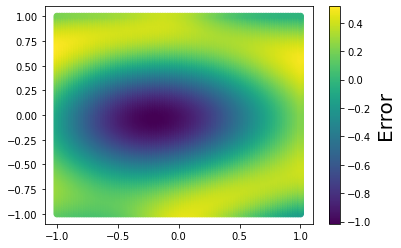

In [12]:
plt.clf()
plt.scatter(xtest.numpy()[:,0], xtest.numpy()[:,1], c = error.numpy())
plt.colorbar().set_label("Error", labelpad = 4, fontsize = 20)


In [13]:
torch.save(net, "value.pth")